In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [5]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

- plot

In [6]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [7]:
def choose_plot_grid(n:int,r_max=8,c_max=17):
    rs = np.sqrt(n)
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where(res==np.min(res))
    #TODO : if len(min_idx) > 1 : minimize abs(sppt-col_nums), col_nums
    return sppt[min_idx[0]], col_nums[min_idx[0]]


def plot_feat_hue(data:pd.DataFrame,hue_label_dict=None):
    num_r, num_c = choose_plot_grid(len(data))
    fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=True,sharey=True)
    for n,ax in enumerate(axes.flatten()):
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        sns.barplot(x=data.iloc[n].index, y = data.iloc[n].values,ax =ax)
        feat_name = data.index[n]
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)

    pass

## LOAD DATA

In [8]:
pvtb_name = 'pvtb_city_total_ver0.csv'


pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_total = pd.read_csv(pvtb_path)

pvtb_total

geo_label_city  date_label  Active Transportation | Riding Bike to Work  \
0           Austin        2010                                     1.458997   
1           Austin        2011                                     1.458997   
2           Austin        2012                                     1.458997   
3           Austin        2013                                     1.326730   
4           Austin        2014                                     1.326730   
..             ...         ...                                          ...   
450     Washington        2018                                     3.316120   
451     Washington        2019                                     3.316120   
452     Washington        2020                                     3.316120   
453     Washington        2021                                     3.316120   
454     Washington        2022                                     3.316120   

     Active Transportation | Walking to Work  \
0                                   2.506039   
1                                   2.506039   
2                                   2.506039   
3                                   2.281223   
4                                   2.281223   
..                                       ...   
450                                10.266102   
451                                10.266102   
452                                10.266102   
453                                10.266102   
454                                10.266102   

     Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                 2.191781                         25.479452   
1                                 3.835616                         38.356164   
2                                 2.185792                         31.967213   
3                                 1.095890                         31.780822   
4                                 0.000000                         31.780822   
..                                     ...                               ...   
450                               1.643836                         35.616438   
451                               1.369863                         33.698630   
452                               0.273224                         14.207650   
453                               2.191781                         30.958904   
454                               1.877934                         28.169014   

     Birth Control | Teen Birth Control  Births | Low Birthweight  \
0                                   NaN                  7.836414   
1                                   NaN                  7.858909   
2                                   NaN                  7.893722   
3                                   NaN                  7.716502   
4                                   NaN                  7.578234   
..                                  ...                       ...   
450                                22.0                 10.107357   
451                                20.8                  9.803055   
452                                20.8                  9.671965   
453                                 NaN                  9.656761   
454                                 NaN                  9.704213   

     Births | Prenatal Care  Births | Preterm Births  ...  \
0                 68.065826                      NaN  ...   
1                 69.538996                      NaN  ...   
2                 72.059393                      NaN  ...   
3                 74.345139                      NaN  ...   
4                 76.014734                      NaN  ...   
..                      ...                      ...  ...   
450               70.844190                10.383966  ...   
451               71.639682                10.117118  ...   
452               72.875092                10.112782  ...   
453               72.056605                10.046893  ...   
454              

<AxesSubplot: >

/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


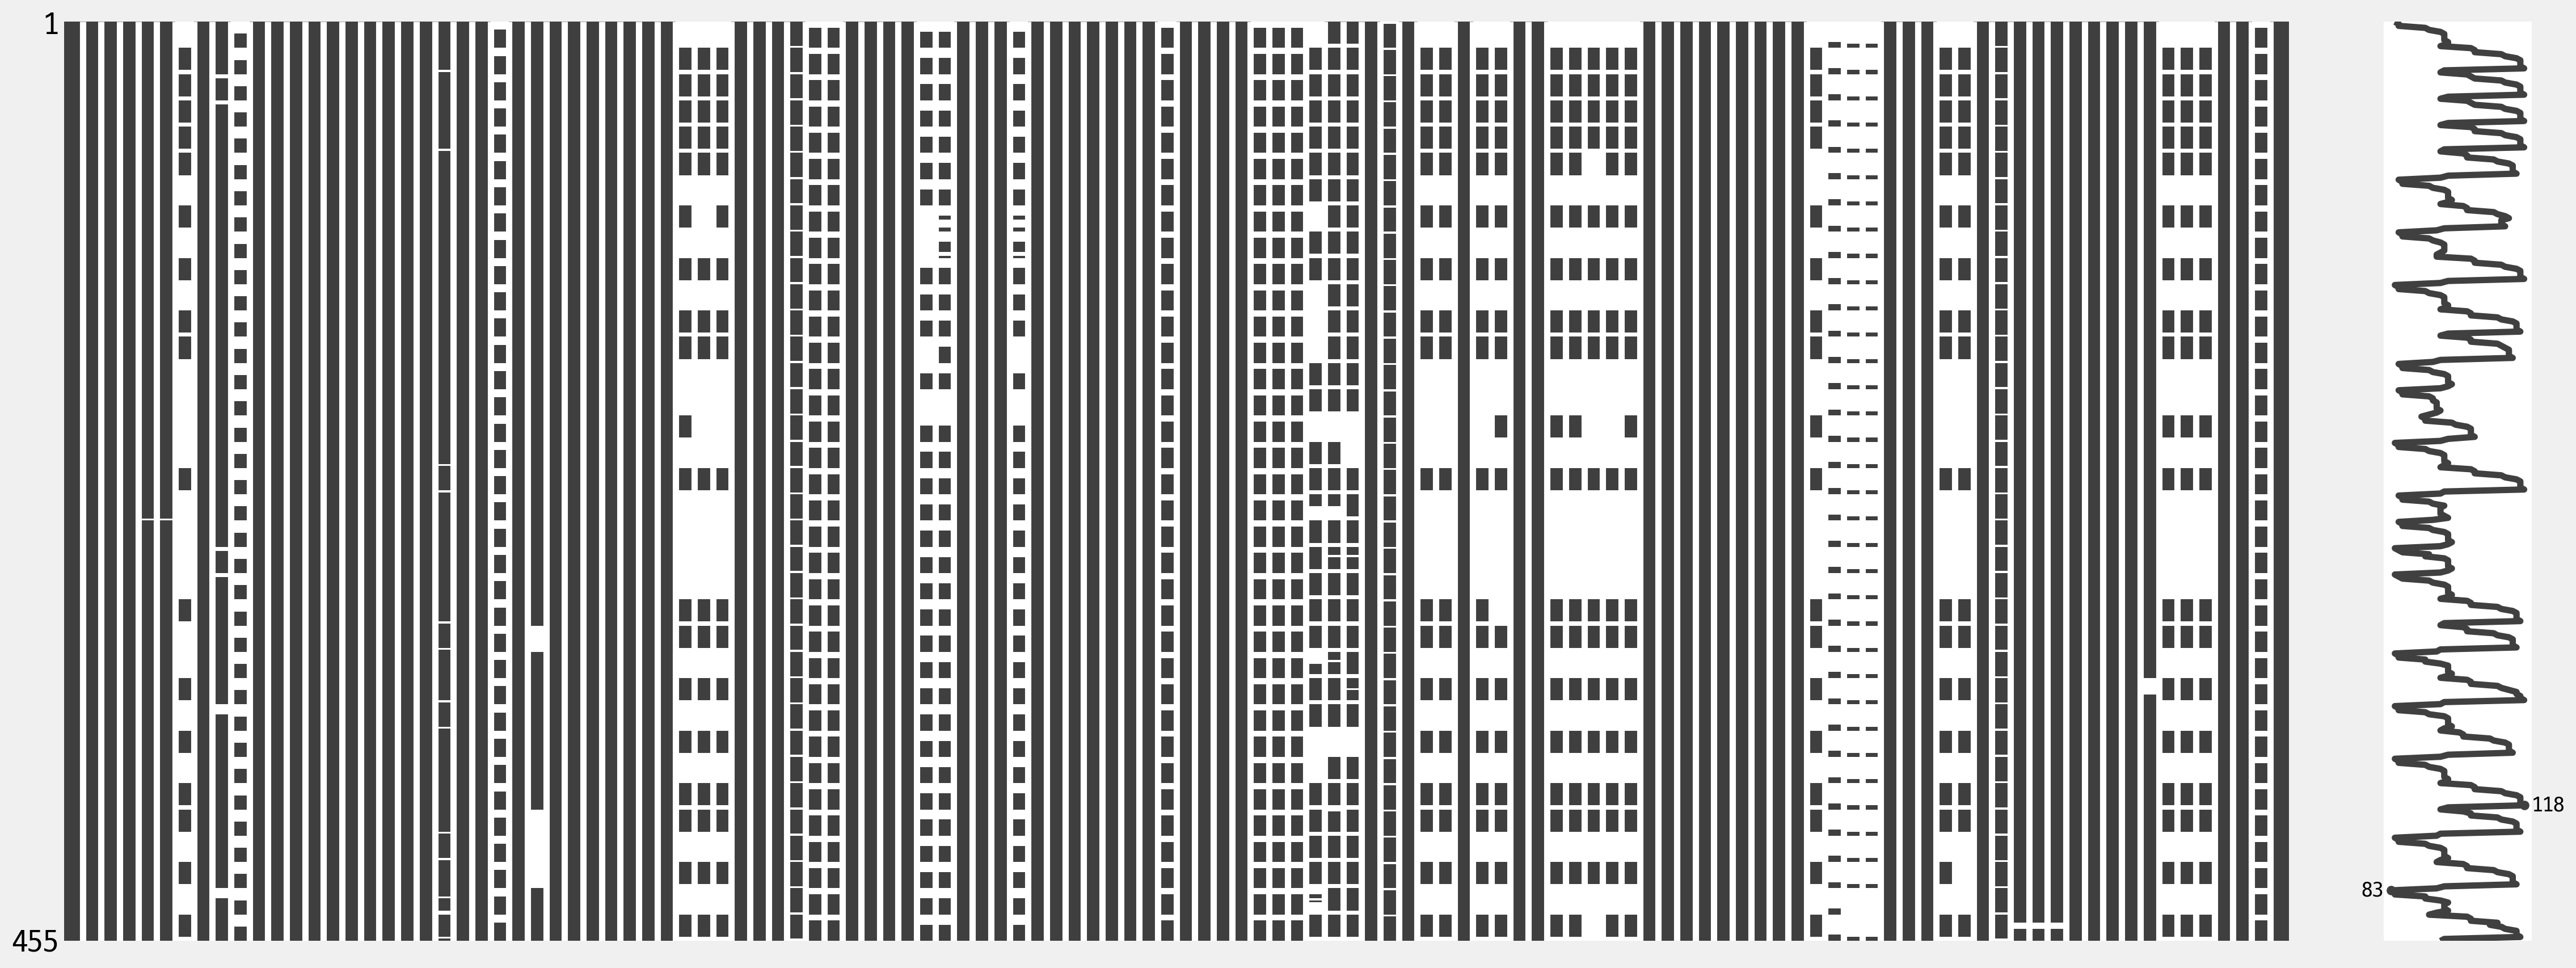

In [9]:
msno.matrix(pvtb_total)

<AxesSubplot: >

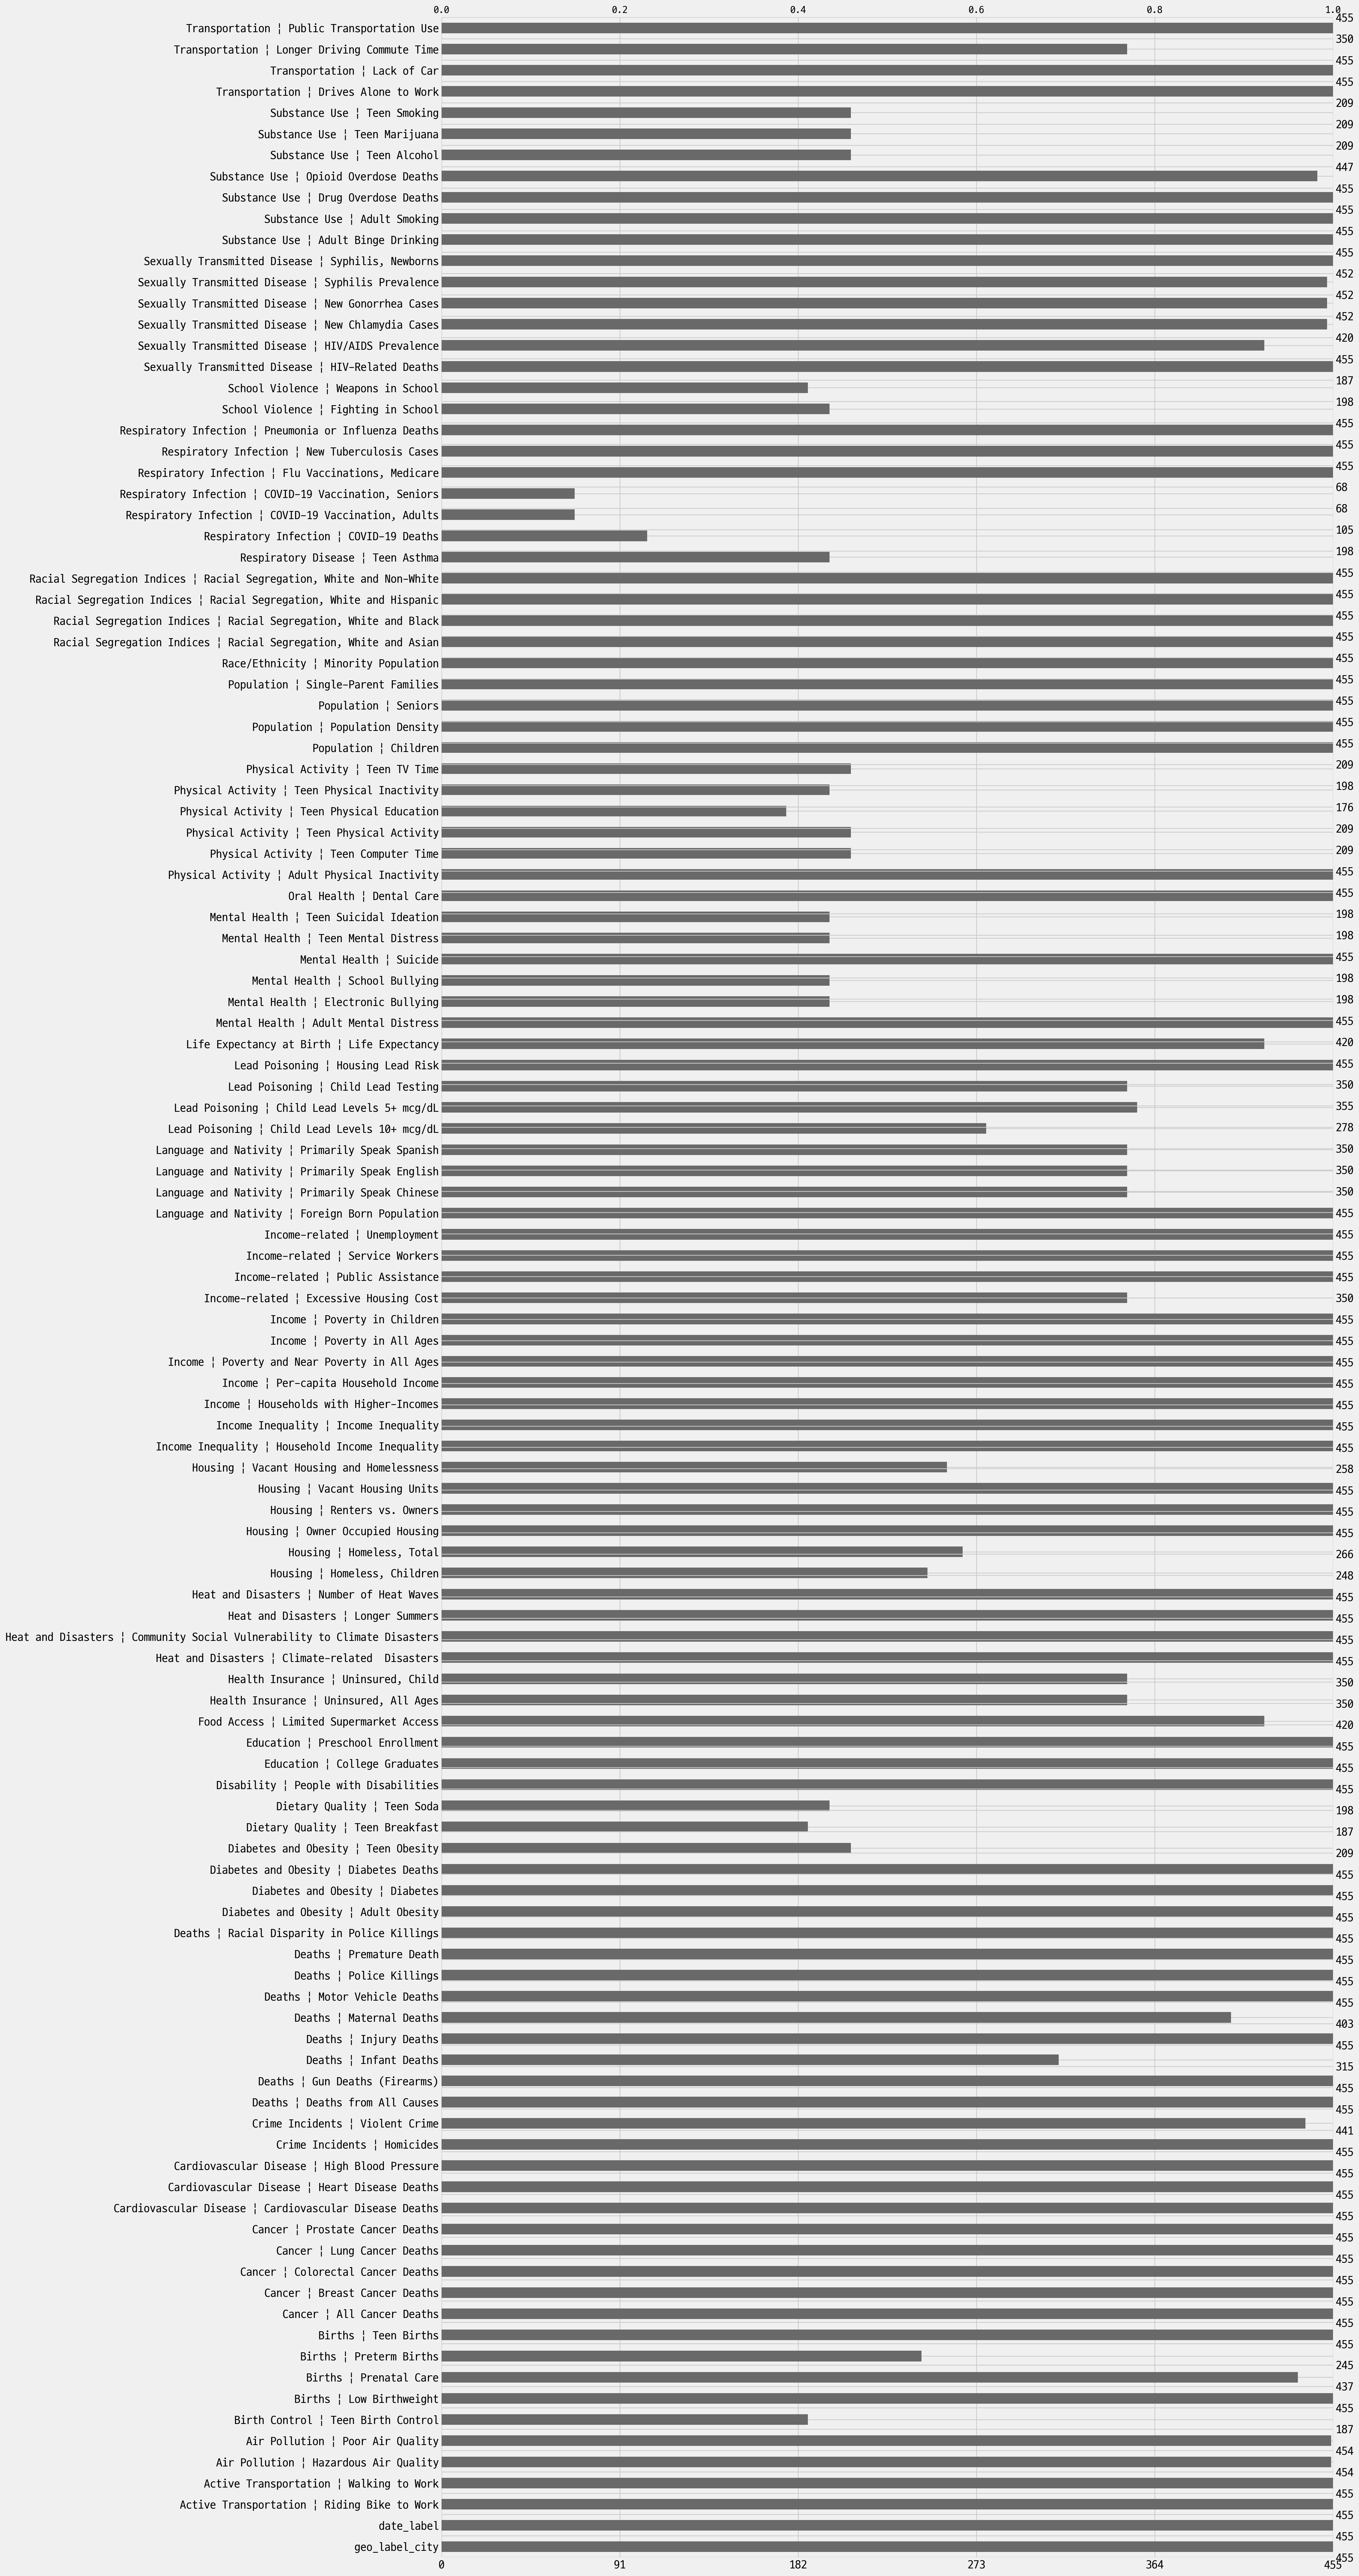

In [10]:
msno.bar(pvtb_total)

<AxesSubplot: >

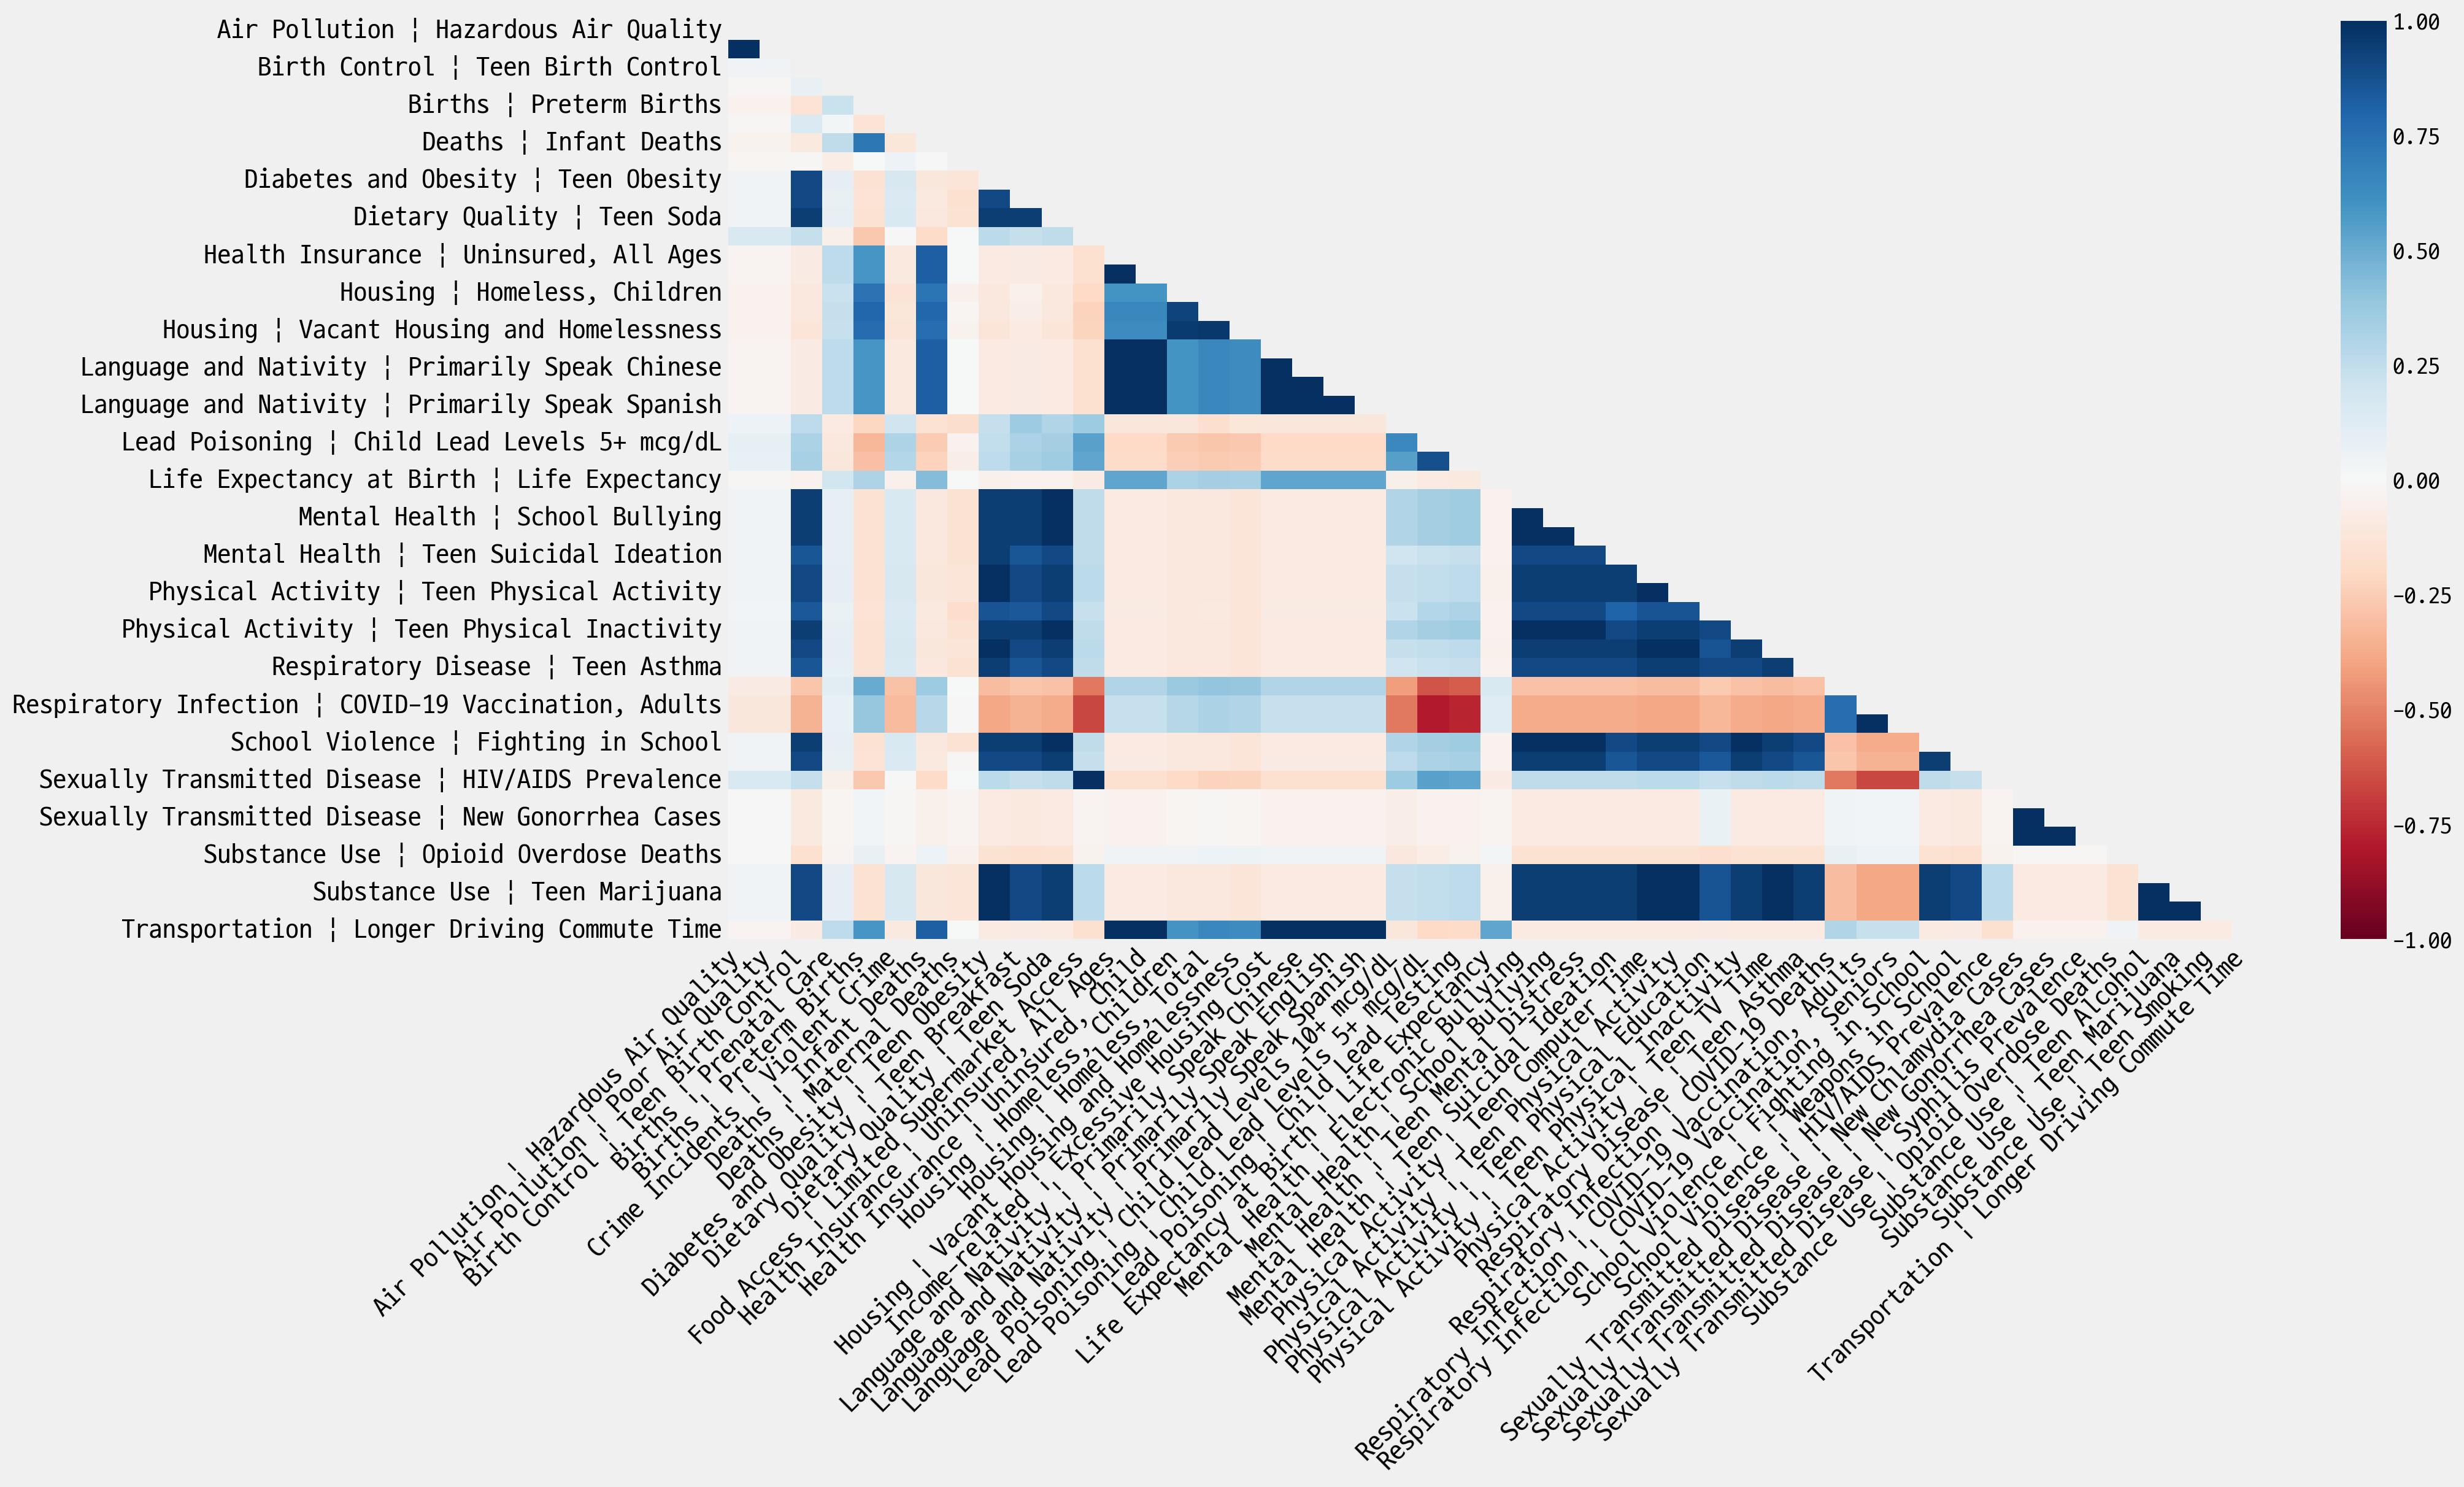

In [11]:
msno.heatmap(pvtb_total, labels=False)

<AxesSubplot: >

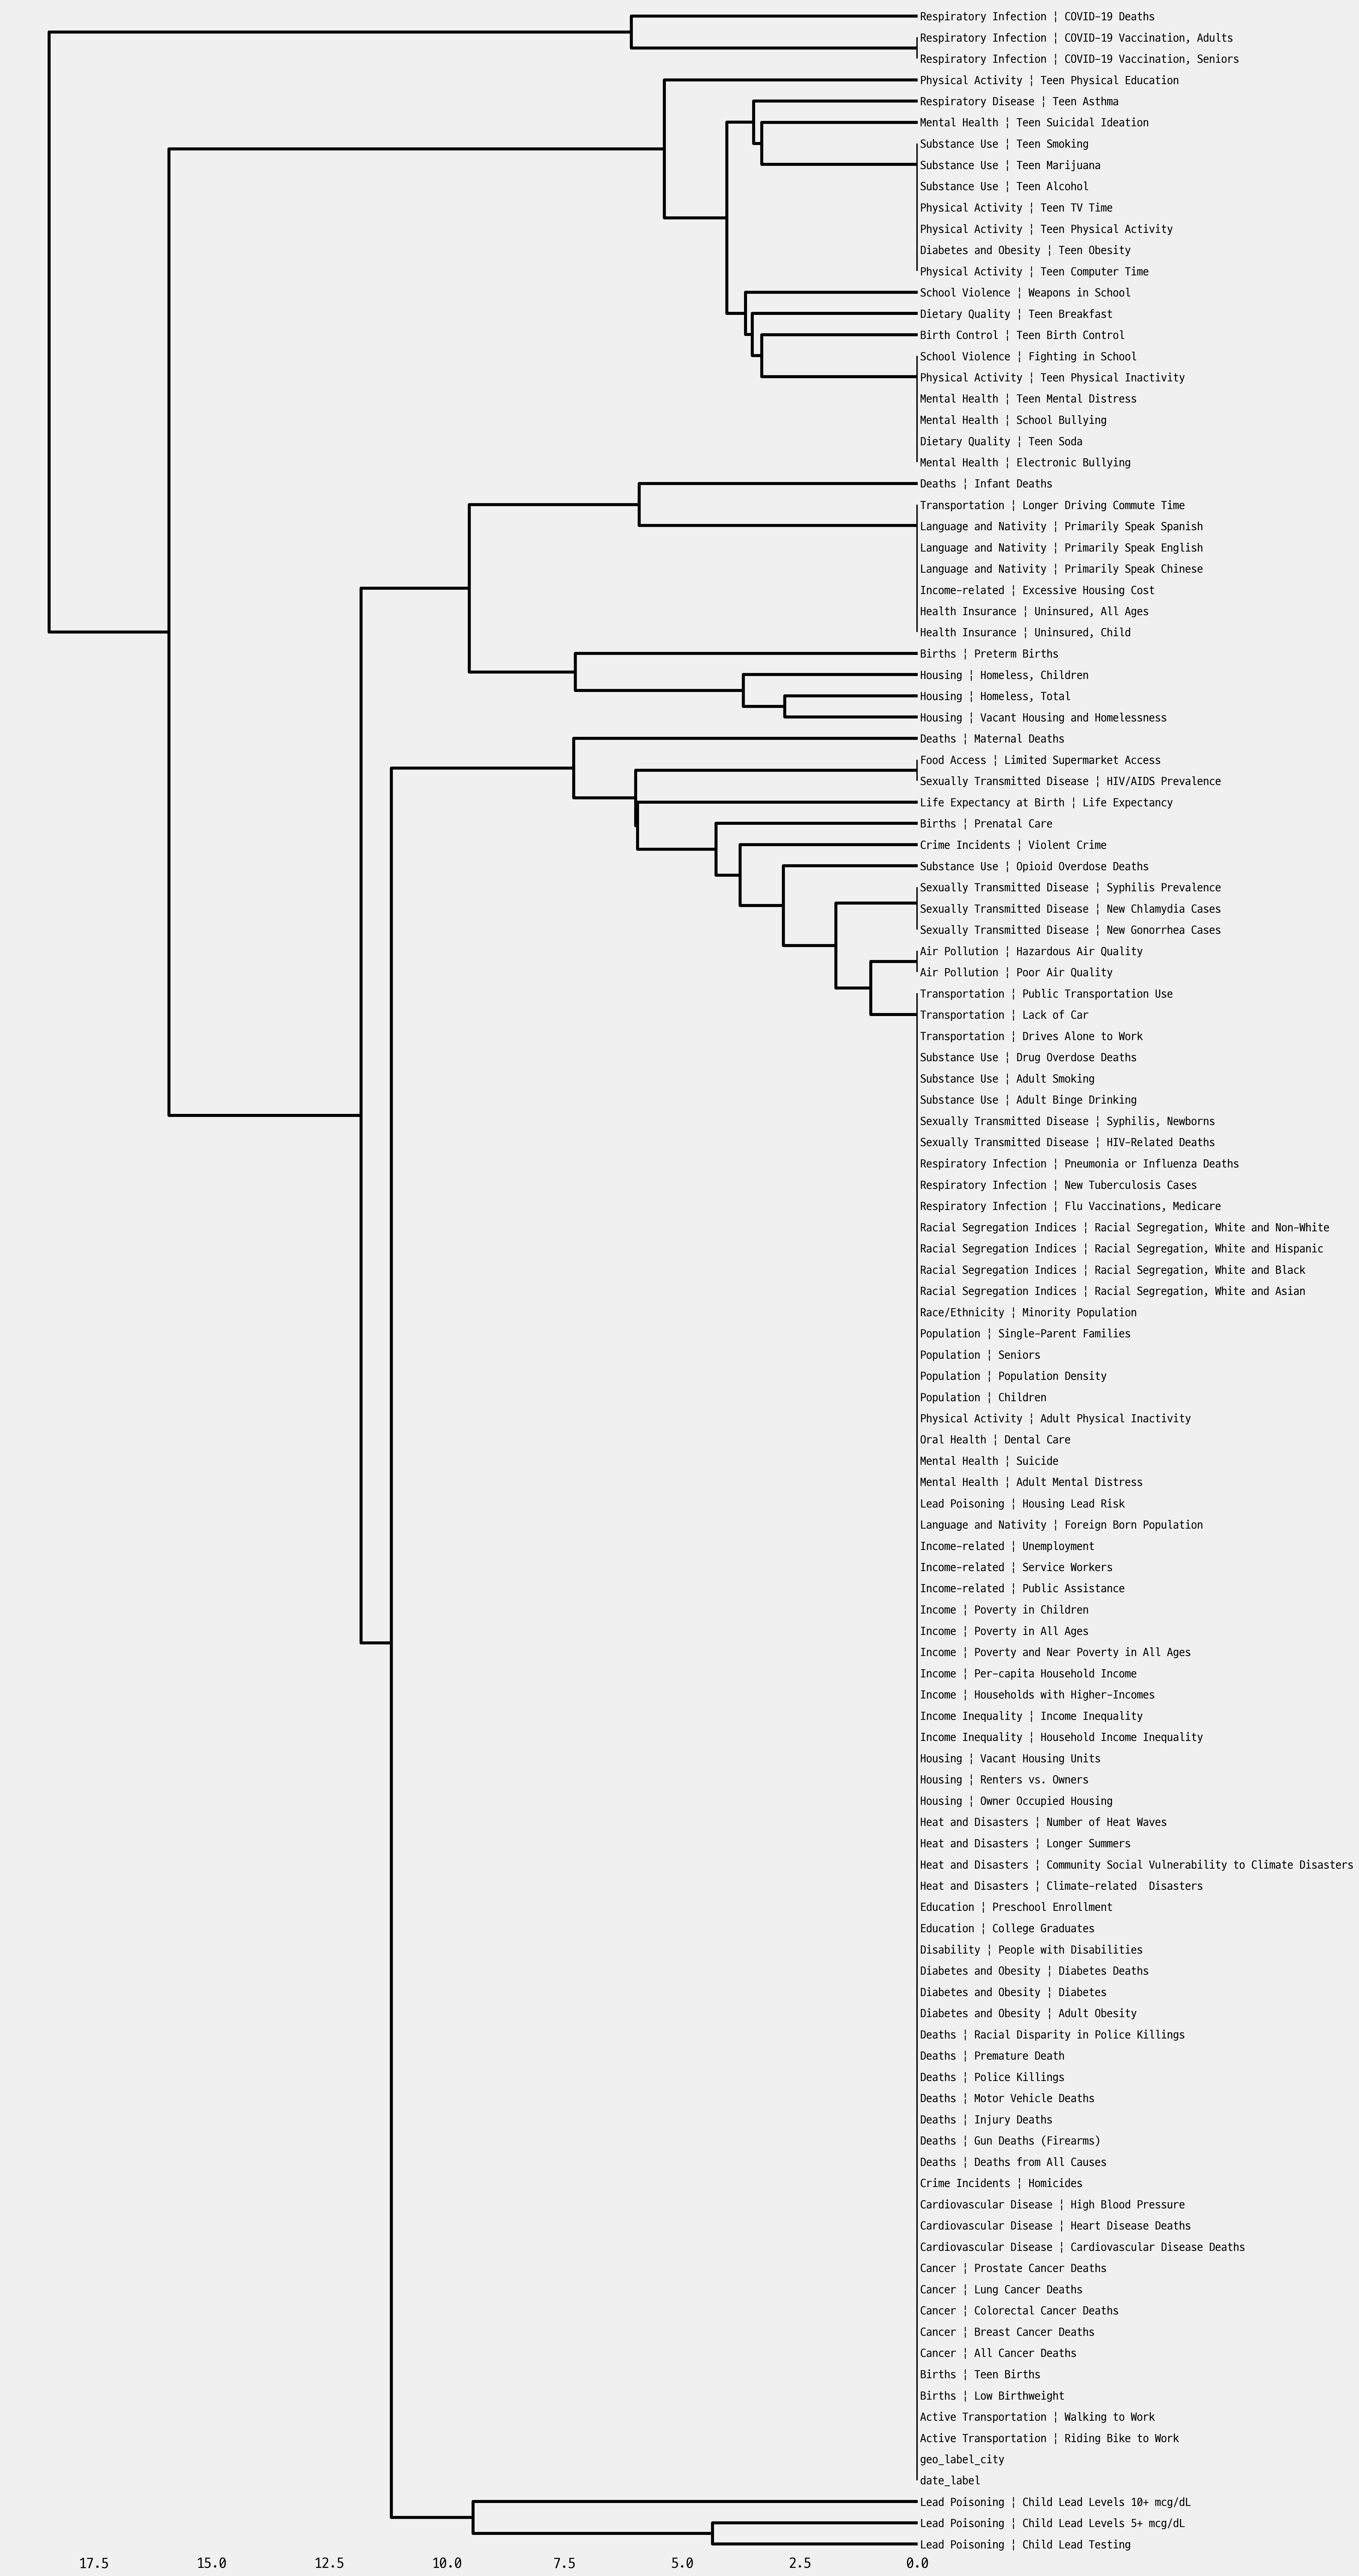

In [12]:
msno.dendrogram(pvtb_total)

In [13]:
labels = pvtb_total.columns[4:]

np.sum(~pvtb_total[labels].isna(),axis=0)

Air Pollution | Hazardous Air Quality           454
Air Pollution | Poor Air Quality                454
Birth Control | Teen Birth Control              187
Births | Low Birthweight                        455
Births | Prenatal Care                          437
                                               ... 
Substance Use | Teen Smoking                    209
Transportation | Drives Alone to Work           455
Transportation | Lack of Car                    455
Transportation | Longer Driving Commute Time    350
Transportation | Public Transportation Use      455
Length: 116, dtype: int64

In [28]:
pvtb_temp = pvtb_total.T

np.sum(np.sum(~pvtb_temp.isna()) == 0)

0

In [40]:
pvtb_temp = pvtb_total.T
len(pvtb_temp[np.sum(pvtb_temp.isna(),axis=1) == 0].index)

71

In [44]:
full_labels = list(pvtb_temp[np.sum(pvtb_temp.isna(),axis=1) == 0].index)

display(full_labels[2:25])

['Active Transportation | Riding Bike to Work',
 'Active Transportation | Walking to Work',
 'Births | Low Birthweight',
 'Births | Teen Births',
 'Cancer | All Cancer Deaths',
 'Cancer | Breast Cancer Deaths',
 'Cancer | Colorectal Cancer Deaths',
 'Cancer | Lung Cancer Deaths',
 'Cancer | Prostate Cancer Deaths',
 'Cardiovascular Disease | Cardiovascular Disease Deaths',
 'Cardiovascular Disease | Heart Disease Deaths',
 'Cardiovascular Disease | High Blood Pressure',
 'Crime Incidents | Homicides',
 'Deaths | Deaths from All Causes',
 'Deaths | Gun Deaths (Firearms)',
 'Deaths | Injury Deaths',
 'Deaths | Motor Vehicle Deaths',
 'Deaths | Police Killings',
 'Deaths | Premature Death',
 'Deaths | Racial Disparity in Police Killings',
 'Diabetes and Obesity | Adult Obesity',
 'Diabetes and Obesity | Diabetes',
 'Diabetes and Obesity | Diabetes Deaths']

In [45]:
display(full_labels[25:50])

['Disability | People with Disabilities',
 'Education | College Graduates',
 'Education | Preschool Enrollment',
 'Heat and Disasters | Climate-related  Disasters',
 'Heat and Disasters | Community Social Vulnerability to Climate Disasters',
 'Heat and Disasters | Longer Summers',
 'Heat and Disasters | Number of Heat Waves',
 'Housing | Owner Occupied Housing',
 'Housing | Renters vs. Owners',
 'Housing | Vacant Housing Units',
 'Income Inequality | Household Income Inequality',
 'Income Inequality | Income Inequality',
 'Income | Households with Higher-Incomes',
 'Income | Per-capita Household Income',
 'Income | Poverty and Near Poverty in All Ages',
 'Income | Poverty in All Ages',
 'Income | Poverty in Children',
 'Income-related | Public Assistance',
 'Income-related | Service Workers',
 'Income-related | Unemployment',
 'Language and Nativity | Foreign Born Population',
 'Lead Poisoning | Housing Lead Risk',
 'Mental Health | Adult Mental Distress',
 'Mental Health | Suicide',
 

In [46]:
display(full_labels[50:])

['Physical Activity | Adult Physical Inactivity',
 'Population | Children',
 'Population | Population Density',
 'Population | Seniors',
 'Population | Single-Parent Families',
 'Race/Ethnicity | Minority Population',
 'Racial Segregation Indices | Racial Segregation, White and Asian',
 'Racial Segregation Indices | Racial Segregation, White and Black',
 'Racial Segregation Indices | Racial Segregation, White and Hispanic',
 'Racial Segregation Indices | Racial Segregation, White and Non-White',
 'Respiratory Infection | Flu Vaccinations, Medicare',
 'Respiratory Infection | New Tuberculosis Cases',
 'Respiratory Infection | Pneumonia or Influenza Deaths',
 'Sexually Transmitted Disease | HIV-Related Deaths',
 'Sexually Transmitted Disease | Syphilis, Newborns',
 'Substance Use | Adult Binge Drinking',
 'Substance Use | Adult Smoking',
 'Substance Use | Drug Overdose Deaths',
 'Transportation | Drives Alone to Work',
 'Transportation | Lack of Car',
 'Transportation | Public Transporta

### 결측치 확인
- 연도/도시 기준으로 결측률
    1. 하나의 데이터라도 있는지가 기준
    2. All-Both가 있는지를 기준
   - stratification data 만을 기준으로 결측률 확인
    3. All, Both 제외 하나라도 있으면 있는 것 기준
    4. All, Both 제외 두 개 이상 있는 것 기준
    5. 전체 race-sex에서 ths 이상 있는 것 기준
        - ths = 0.5, 0.7

1. 각 label 별로 7*17 에 plot
    - count/ ratio
2. y축 label, x축 연도로 해서 plot
    - 이 경우 ratio를 기준으로 색을 할 수 있을 것 같음
        - 도시 별로 집계한 것을 다시 집계하는 것은 큰 의미가 없을 듯
    - heatmap으로 그리면 될 듯 
3. y축 label, x축 도시로 해서 plot
    - 도시간 정렬은 records 양 순서대로
4. (2와 3통합)

In [14]:
pvtb_total['geo_label_city'].value_counts()

geo_label_city
Austin           13
Phoenix          13
Milwaukee        13
Minneapolis      13
New York City    13
Oakland          13
Oklahoma City    13
Philadelphia     13
Portland         13
Louisville       13
San Antonio      13
San Diego        13
San Francisco    13
San Jose         13
Seattle          13
Tucson           13
Memphis          13
Los Angeles      13
Baltimore        13
Denver           13
Boston           13
Charlotte        13
Chicago          13
Cleveland        13
Columbus         13
Dallas           13
Detroit          13
Long Beach       13
El Paso          13
Fort Worth       13
Houston          13
Indianapolis     13
Kansas City      13
Las Vegas        13
Washington       13
Name: count, dtype: int64

- 각 (인종,성별,도시,연도) tuple 별로 각 라벨에서의 데이터 값에 대해서 sppt에서의 거리와 label value에서의 거리 사이에 비교
    - sppt 에서의 metric
        - 각각의 차원에서의 거리를 규정한 뒤, 각 차원에서의 거리를 euclidean
            - 각각의 차원에서의 거리에 붙어야 할 계수를 회귀로 구할 수 있음
            - 각각의 차원에서의 거리를 통해, 전체 차원에서의 거리를 구하는 방법을 NN으로 구할 수 있음
        - 인종, 성별 : all, both 와의 거리는 다른 집단과의 거리보다 짧게
        - 도시 : 도시에 대한 geo_strata 정보를 기준으로 metric 정의
            - geo_strata의 feature : region, poverty, population, popDensity, segration
            - 추가적으로 feature를 더한다면 : 내륙/해안/접경, 위도경도
            - geo_strata의 값이 연도 별로 달라지는 지 확인
        - 연도 : 차이